### Apply ANNs to ANY dataset!
Building a model with the iris dataset was nice and all, but that data is a bit too clean than what we can expect in the "real world". The features were continuous #s on the same scale. There were no categorical variables. We didn't have to do any feature engineering. And there was a "clean" set of 3 target classes. How do we extend ANNs to more realistic tabular data?

For this example, we'll use some NY Taxi data. Given a set of several features - lat/long, pickup time, day of week, distance of ride, ..., can we predict the price of the taxi ride?

### Feature Engineering
Turn lat/long and datetime cols into useful features

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in data
df = pd.read_csv('../Data/NYCTaxiFares.csv')  # 120k records of over 55M dataset on kaggle
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

Haversine formula:

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

In [8]:
# 1) Feature engineer the lat/long pickup and dropoffs to determine distance travelled. We will use the haversine formula to calculate the distance between 2 lat/long coord pairs on a sphere

def haversine_distance(df, lat1, long1, lat2, long2):
    """Calculates the haversine distance between 2 sets of GPS coords in df
    """
    r = 6371  # avg radius of Earth in km
    
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[long2] - df[long1])

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = r*c  # in km

    return d

In [9]:
# We now engineer the new "distance_km" feature, which is more useful than some of the original feats
df['distance_km'] = haversine_distance(
    df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'
)
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [10]:
# Convert pickup_datetime into date
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [12]:
# Convert UTC time into EST
df['pickup_EST'] = df['pickup_datetime'] - pd.Timedelta(hours=4)
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_EST
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00


In [19]:
df['hour'] = df['pickup_EST'].dt.hour
df['am'] = np.where(df['hour'] < 12, 1, 0)
df['weekday'] = df['pickup_EST'].dt.strftime('%a')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,pickup_EST,Hour,weekday,am,hour
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,Mon,1,4
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,Sat,1,11
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,Sat,1,7
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,Sun,0,17
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,Fri,0,22


In [20]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km', 'pickup_EST', 'Hour', 'weekday', 'am',
       'hour'],
      dtype='object')

In [38]:
# Separate categorical from continuous columns
cat_cols = ['hour', 'weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'distance_km']
target = 'fare_amount'  # We will treat this as a regression problem where we try to predict fare amount

In [39]:
# Change categorical cols to category dtype
for cat in cat_cols:
    df[cat] = df[cat].astype('category')
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
distance_km                      float64
pickup_EST           datetime64[ns, UTC]
Hour                               int64
weekday                         category
am                                 int32
hour                            category
dtype: object

In [40]:
df['hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [41]:
df['weekday'].head()

0    Mon
1    Sat
2    Sat
3    Sun
4    Fri
Name: weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [48]:
# Turn categorical cols into numpy arrays (then pt tensors)
hr = df['hour'].cat.codes.values
wkday = df['weekday'].cat.codes.values
cats = np.stack([hr, wkday], axis=1)
cats

array([[ 4,  1],
       [11,  2],
       [ 7,  2],
       ...,
       [14,  3],
       [ 4,  5],
       [12,  2]], dtype=int8)

In [49]:
# OR, as a one-liner...
# cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
# cats

In [53]:
# Convert to pt tensor
cats = torch.tensor(cats, dtype=torch.int64)
conts = np.stack([df[col].values for col in cont_cols], axis=1)
conts = torch.tensor(conts, dtype=torch.float)

C:\Users\611391\AppData\Local\Temp\1\ipykernel_6224\366457008.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cats = torch.tensor(cats, dtype=torch.int64)


In [59]:
# reshape to get column shape instead of 1 long row
y = torch.tensor(df[target].values, dtype=torch.float).reshape(-1,1)
print(y)

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])


In [60]:
# Determine length of categories
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
cat_szs

[24, 7]

### Use embeddings
Create a simple lookup table of embeddings for a fixed dict of fixed size. This is the one-hot encoding that happens to the categories. Used to store word vals and retrieve them using indices

In [61]:
# General rule of thumb is have at most n/2 embeddings, where n is the # of categories in a column. You shouldn't have more than 50 "embeddings" for a col
emb_szs = [(size,min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (7, 4)]

In [62]:
cats_samp = cats[:4]
cats_samp

tensor([[ 4,  1],
        [11,  2],
        [ 7,  2],
        [17,  3]])

In [63]:
# Pass cats_samp to embeddings module
[nn.Embedding(ni,nf) for ni,nf in emb_szs]

[Embedding(24, 12), Embedding(7, 4)]

In [64]:
self_embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
self_embeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(7, 4)
)

In [66]:
embeds = []
for i,e in enumerate(self_embeds):
    embeds.append(e(cats_samp[:,i]))
embeds

[tensor([[-1.2877, -0.0435, -0.7732, -0.5115,  0.5904, -0.3110, -1.6055,  1.2114,
          -0.2185,  0.4973,  1.5281, -0.4427],
         [-0.9393,  0.4208,  0.6840, -0.9744,  0.5183,  0.8890,  0.2936,  1.0225,
          -1.3656, -0.0931,  1.2937,  0.3370],
         [ 2.0962,  0.2778, -0.0421, -0.7980, -0.2629,  0.1632,  1.7110,  0.1005,
           0.1313, -0.6661,  0.4016,  0.5963],
         [-1.3548, -1.4300,  0.4957, -0.2133, -0.2950, -1.8935,  0.0360, -1.5099,
          -0.6332,  1.4029, -0.8556, -0.2158]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.6259,  1.1616,  0.2627,  0.3133],
         [-2.0431,  0.1125,  2.0101,  0.6187],
         [-2.0431,  0.1125,  2.0101,  0.6187],
         [-0.8763, -0.8471, -0.9316, -0.7833]], grad_fn=<EmbeddingBackward0>)]

In [67]:
# These are randomly assigned values that get assigned during .forward. They get modified as we continue to train. This lets us put more weight on certain hours of the day, or certain days of the week as the model sees fit.
z = torch.cat(embeds,1)
z

tensor([[-1.2877, -0.0435, -0.7732, -0.5115,  0.5904, -0.3110, -1.6055,  1.2114,
         -0.2185,  0.4973,  1.5281, -0.4427, -0.6259,  1.1616,  0.2627,  0.3133],
        [-0.9393,  0.4208,  0.6840, -0.9744,  0.5183,  0.8890,  0.2936,  1.0225,
         -1.3656, -0.0931,  1.2937,  0.3370, -2.0431,  0.1125,  2.0101,  0.6187],
        [ 2.0962,  0.2778, -0.0421, -0.7980, -0.2629,  0.1632,  1.7110,  0.1005,
          0.1313, -0.6661,  0.4016,  0.5963, -2.0431,  0.1125,  2.0101,  0.6187],
        [-1.3548, -1.4300,  0.4957, -0.2133, -0.2950, -1.8935,  0.0360, -1.5099,
         -0.6332,  1.4029, -0.8556, -0.2158, -0.8763, -0.8471, -0.9316, -0.7833]],
       grad_fn=<CatBackward0>)

In [68]:
# Add embeddings to dropout layer. During training, dropout layers will randomly zero some of the elements of the input tensor with a probability you specify - randomly turn off n% of the neurons. This is a common method used to combat overfitting.
selfembdrop = nn.Dropout(0.4)

In [69]:
z = selfembdrop(z)
z

tensor([[-2.1461, -0.0725, -0.0000, -0.8524,  0.9839, -0.5184, -0.0000,  2.0190,
         -0.3641,  0.0000,  2.5468, -0.7379, -0.0000,  1.9360,  0.4378,  0.5221],
        [-0.0000,  0.7013,  0.0000, -1.6240,  0.8638,  1.4816,  0.0000,  1.7042,
         -2.2760, -0.0000,  2.1561,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.4630, -0.0000, -1.3300, -0.4381,  0.0000,  2.8517,  0.1675,
          0.0000, -0.0000,  0.0000,  0.9938, -3.4052,  0.1876,  3.3501,  1.0312],
        [-2.2579, -2.3834,  0.0000, -0.0000, -0.0000, -3.1558,  0.0000, -2.5165,
         -1.0553,  2.3381, -1.4261, -0.3597, -1.4605, -1.4118, -1.5527, -1.3056]],
       grad_fn=<MulBackward0>)

### Define the tabular model
Blueprint to apply to similar datasets as NYTaxi (mix of categorical and continuous feats)

In [78]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        """Define TabularModel

        :param emb_szs: List of tuples, each categorical var size is paired with an embedding size (n/2)
        :type emb_szs: list
        :param n_cont: # of continuous vars
        :type n_cont: int
        :param out_sz: Output size
        :type out_sz: int
        :param layers: Layer sizes
        :type layers: list
        :param p: Probability for each layer, defaults to 0.5
        :type p: float, optional
        """
        # layers = [200,100,50]

        super().__init__()

        # Create embeddings for categorical feats. Categorical data is filtered through these embeddings in the forward section
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        # Create dropout layer
        self.emb_drop = nn.Dropout(p)
        # Normalize continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)

        # Establish sequence of neural network layers. Each layer includes a linear function, an activation function (ReLU), a normalization step and a dropout layer
        layerlist = []
        n_embs = sum([nf for ni,nf in emb_szs])
        n_in = n_embs + n_cont

        # Iteratively build network based on layers param
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i

        # Output linear layer
        layerlist.append(nn.Linear(layers[-1], out_sz))

        # Combine list of layers
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        """Define forward method. Preprocess embeddings and normalize continuous vars before passing them through layers

        :param x_cat: Categorical features
        :type x_cat: _type_
        :param x_cont: Continuous features
        :type x_cont: _type_
        :return: _description_
        :rtype: _type_
        """
        embeddings = []

        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))

        # Combine categorical embeddings
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)

        # Add continuous feats to embeddings
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        return x

### Create and train model

In [79]:
model = TabularModel(emb_szs=emb_szs, n_cont=conts.shape[1], out_sz=1, layers=[200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [80]:
# Classify loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [82]:
# Train/test splits
from cgi import test


batch_size = 60000
test_size = int(0.2*batch_size)

# Data is already shuffled!
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:]

y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:]

In [86]:
import time
start = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))  # RMSE
    losses.append(loss)
    if i%25 == 1:
        print(f'Epoch: {i} \t Loss: {loss}')
    
    optimizer.zero_grad()  # Look for where gradient is zero
    loss.backward()  # Step backward through network
    optimizer.step()  # Update hyperparams

elapsed = time.time() - start
print(f'All done! Training took {round(elapsed/60, 2)} minutes.')

Epoch: 1 	 Loss: 12.449496269226074
Epoch: 26 	 Loss: 10.611578941345215
Epoch: 51 	 Loss: 10.060690879821777
Epoch: 76 	 Loss: 9.664444923400879
Epoch: 101 	 Loss: 9.136228561401367
Epoch: 126 	 Loss: 8.392516136169434
Epoch: 151 	 Loss: 7.388148784637451
Epoch: 176 	 Loss: 6.182623863220215
Epoch: 201 	 Loss: 4.956921577453613
Epoch: 226 	 Loss: 4.142727375030518
Epoch: 251 	 Loss: 3.811774492263794
Epoch: 276 	 Loss: 3.7232067584991455
All done! Training took 1.0 minutes.


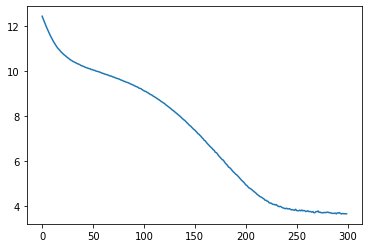

In [91]:
# Plot loss function
plt.plot(range(epochs), [el.item() for el in losses])

### Validate model on test set

In [94]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
loss
# Loss matches what we see towards the end of the model training, indicating we are likely not overfitting

tensor(3.6658)

In [107]:
for i in range(10):
    print(f'''{i})\nPredicted: {y_val[i].item():8.2f} | Actual: {y_pred[i].item():8.2f}''')

0)
Predicted:     2.74 | Actual:     7.09
1)
Predicted:    20.53 | Actual:     6.20
2)
Predicted:     5.59 | Actual:     9.16
3)
Predicted:    10.01 | Actual:     6.70
4)
Predicted:     4.36 | Actual:    14.14
5)
Predicted:     6.67 | Actual:     4.18
6)
Predicted:     4.59 | Actual:     4.25
7)
Predicted:    14.49 | Actual:     6.30
8)
Predicted:     7.14 | Actual:     3.51
9)
Predicted:     8.88 | Actual:     6.55


In [108]:
# Model as a whole performs pretty well. The average difference between predicted and actual price is around $3. Some predicted prices are a bit far off, while others tend very close to the actual price.

In [ ]:
# Save the model